<a href="https://colab.research.google.com/github/Kate-Cher/BI_ML_python_2021/blob/main/Music_clust.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music clusterization and classification

This project is focused on music clusterization and classification.

The authors:
* Anna Rybina
* Ekaterina Chernyavskaya
* Daria Nikanorova
* Eugenia Ivanova
* Maxim Serdakov 

# Packages and libraries

In [3]:
!pip install Levenshtein -qq
! pip install scikit-multilearn -qq
! pip install arff -qq

     |████████████████████████████████| 163kB 5.3MB/s 
     |████████████████████████████████| 92kB 3.8MB/s 


In [26]:
from Levenshtein import distance
import numpy as np
import pandas as pd
from collections import Counter
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import librosa.display
import sklearn
import os
import csv
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")

from sklearn import decomposition
from sklearn import metrics

from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, v_measure_score

# KNN classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.multioutput import ClassifierChain

# Additional packages to preprocess data for keras model
from sklearn.preprocessing import LabelEncoder

# Additionl packages to set random seed for keras model
import os
import random
import tensorflow as tf
from keras import backend as K

# Keras
import keras
from keras import models
from keras import layers
from keras import metrics

# Additionl packages for keras model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import random 
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score

# Compute statistics, keras model
from scipy import stats


from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.manifold import TSNE
from sklearn import preprocessing
from collections import Counter
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC


%matplotlib inline


In [ ]:
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

# Data correction

In [ ]:
df = pd.read_csv('genres.csv')
df.head()

,student,song,coarse_genre,genre1,genre2,genre3
0,Алексей Замалутдинов,Белый теплоход-Синяя_птица.mp3,Pop,Classic russian pop,Chanson,NaN
1,Алексей Замалутдинов,Дрозды-Геннадий_Белов.mp3,Pop,Classic russian pop,NaN,NaN
2,Алексей Замалутдинов,Птица_счастья_выбери_меня-Гнатюк.mp3,Pop,Classic russian pop,NaN,NaN
3,Алексей Замалутдинов,У_школьного_порога-Геннадий_Белов.mp3,Pop,Classic russian pop,NaN,NaN
4,Алексей Замалутдинов,Je_veux-Zaz.mp3,Jazz,french jazz,Chanson,NaN


We observed NaN values presence. So we checked whether our songs were balanced by the coarse_genre:

In [ ]:
df.coarse_genre.value_counts()

Our songs were imbalanced. Also there were some mistakingly named genres and different recording format, so we decided to correct some mistakes using Levenshtein distances between strings.

In [ ]:
# creation of the value matrix and changing values on the basis of the Levenshtein distances
def collect_values(values_list):  # list of all genres, concatenated
    values_matrix = np.array([[distance(i, j) for i in values_list ] for j in values_list])
    values_count = dict(Counter(values_list))
    for i in range(len(values_list)):
        for j in range(len(values_list)):
            if (values_matrix[i, j] <= 2) and (i != j):  # replacement by more frequent values
                  if values_count[values_list[i]] >= values_count[values_list[j]]:
                    values_list[j] = values_list[i]
                  else:
                    values_list[i] = values_list[j]
    return values_list

In [ ]:
# edition of the particular columns in data frame
def edit_values(df, *args):  # in args must be pd.Series
    list_of_values = []
    for serie in args:
        list_of_values += [item.lower() for item in list(serie.values)]
    corrected_values = collect_values(list_of_values)
    final_list = [corrected_values[i:i + df.shape[0]] for i in range(0, len(corrected_values), df.shape[0])]
    for part in range(0, len(args)):
        df = df.replace(list(args[part].values), final_list[part])
    return df

Before the correction itself we replaced NaN values in genres by 'unknown' value in order to keep the list length unchanged.

In [ ]:
# replacement of the NaN values by 'unknown' and correction of genres
df_without_na = df.fillna('unknown')
df_edited = edit_values(df_without_na,
                        df_without_na.coarse_genre,
                        df_without_na.genre1,
                        df_without_na.genre2,
                        df_without_na.genre3)


Checked the balance again:

In [ ]:
df_edited.coarse_genre.value_counts()

unknown             313
gothic_metal         11
djent                 3
russian synthpop      3
pop_rock              3
pop                   2
russian hip-hop       2
jazz                  2
alternative_rock      2
russian indian        1
experimental          1
swing                 1
emo                   1
hardcore              1
francoton             1
stoner                1
piano                 1
remix                 1
metal                 1
techno                1
Name: genre3, dtype: int64

Our songs still were imbalanced. Therefore we chose 5 most represented coarse genres for almost all the rest manipulations. Also to improve clasterization and classification, we added extra songs from GTZAN Dataset (https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification)

In [ ]:
# Correction of the song names for the nextstep - feature extraction
df_edited['song'] = df_edited['song'].str.replace('.mp3', '')
df_edited.to_csv('Edited.csv')

# Feature extraction

In [ ]:
def create_file_with_header(file):
    header = 'filename chroma_stft rms spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header = header.split()
    file = open(file, 'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(header)

In [ ]:
def extract_features(path_to_audios, output_file):
    for filename in os.listdir(path_to_audios):
        print(filename)
        songname = f'{path_to_audios}{filename}'
        print(songname)
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        file = open(output_file, 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [ ]:
# Example pathways
path_to_df = "/media/daria/DaryaNika/IB_fall2020/ML/music/tmp.csv"
path_to_music = "/media/daria/DaryaNika/IB_fall2020/ML/music/"

In [ ]:
create_file_with_header(path)

In [ ]:
extract_features(path_to_music, path_to_df)

After the feature extraction, addition of the extra songs and final correction of the song names we save two data frames: with 26 and 55 features. Obtained datasets are available for uploading and further analysis!

In [ ]:
data_less = pd.read_csv('music_data.csv')
data_more = pd.read_csv('music_data_new_features.csv')

# K-means clusterization

## Clusterization by the 5 most represented genres

The code of this part was executed on two datasets: with 26 and 55 features.

In [ ]:
tracks = data_less  # change on 'data_more'
tracks.drop(['label'], axis=1, inplace=True)  # required only for data_less dataset
coarse_genres = tracks.coarse_genre.value_counts()
genres_5 = list(coarse_genres[coarse_genres > 70].index)
tracks = tracks.loc[tracks.coarse_genre.isin(genres_5)]
major_genre = tracks.coarse_genre.value_counts().index
X_hist = tracks.drop(['song', 'coarse_genre', 'genre1', 'genre2', 'genre3'], axis=1)
tracks.coarse_genre.value_counts()

In [ ]:
X_hist.hist(figsize=(20,20))

The features appeared to be in a different order of values. To reduce effects of different scaling we normalized the data.

In [ ]:
audio_cols = X_hist.columns.to_list()
norm = Normalizer()
tracks[audio_cols] = norm.fit_transform(tracks[audio_cols])
genre_groupby = tracks.groupby('coarse_genre').agg('mean')
clusters = genre_groupby.reset_index().rename({'coarse_genre':'cluster'}, axis=1)
clusters['method'] = 'Mean'

In [ ]:
# compute number of clusters
plt.rcParams['axes.facecolor'] = 'w'
X = tracks[audio_cols]
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0)
    km.fit(X)
    distortions.append(np.sqrt(km.inertia_))

# plot
plt.rcParams['axes.facecolor'] = 'w'
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')
plt.savefig('Clusters_number.png')
plt.show()

In [ ]:
# K-means
km = KMeans(n_clusters=len(major_genre), n_init=10, random_state=1986)
km.fit(X)
labels = km.labels_
cluster_centers = km.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
km_clusters = pd.DataFrame(cluster_centers, columns=audio_cols)
km_clusters['cluster'] = ['KM{}'.format(l) for l in labels_unique]
km_clusters['method'] = 'KMeans'
clusters = pd.concat([clusters, km_clusters])
cols = ['cluster'] + audio_cols + ['method']
clusters = clusters[cols]
descriptive_labels = list(km_clusters.cluster.values)
unique_labels = np.unique(labels)
translated_labels = dict(zip(unique_labels, descriptive_labels))
tracks['KMeansLabel'] = list(map(lambda x:translated_labels[x], labels))

In [ ]:
# Metrics
y_true = tracks['coarse_genre']
y_pred = tracks['KMeansLabel']
metrics = {'adjusted_rand_score':adjusted_rand_score, 
           'adjusted_mutual_info_score':adjusted_mutual_info_score, 
           'v_measure_score':v_measure_score
          }
scores = dict(zip(metrics.keys(), [metrics[m](y_true, y_pred) for m in metrics.keys()]))
scores['silhouette_score'] = silhouette_score(X,y_pred)
for k,v in scores.items():
    print("Metric: {} Score: {}".format(k, v))

In [ ]:
# PCA for dimension reduction
pca = PCA(n_components=2)
X_new = pca.fit_transform(X)
x,y = zip(*X_new)
tracks['x'] = x
tracks['y'] = y
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

In [ ]:
# Clusters by genres
sns.set(font_scale=1.5)
sns.set_style('white')
sns.lmplot(data=tracks, x='x', y='y', hue='coarse_genre', fit_reg=False, legend=True, size=8, palette='Set1',
           scatter_kws={'alpha':0.35, 's':25})
plt.title("Clustering by Genre, Reduced Dimension", size=15)
plt.grid()
plt.savefig('pca_scatter_genres.png')

In [ ]:
# Clusters by Kmeans
sns.set(font_scale=1.5)
sns.set_style('white')
sns.lmplot(data=tracks, x='x', y='y', hue='KMeansLabel', fit_reg=False, legend=True, size=8, palette='Set1',
           scatter_kws={'alpha':0.35, 's':25})
plt.title("Clustering by KMeans Label, Reduced Dimension")
plt.grid()
plt.savefig('pca_scatter_KM.png')

We obtained illegible clusters with bad metrics. Addition of the features made the situation even slightly worse. According to the computation of clusters number we had about 1-2 clusters for 5 genres. As an option, further we watched how all the genres can be combined in 5 major genres and how this approach affect the results of clusterization.

## Clusterization by the 5 synthetic genres

The code of this part was executed on two datasets: with 26 and 55 features. This code has similarities with previous part in order to be fully independent.

All genres in the coarse_genre variable were united in 5 synthetic genres on the basis of the distances between them, calculated by the corresponding feature values. Initial code was taken from here https://github.com/victoreram/Springboard-Data-Science/blob/master/GenreClustering/GenreClustering.ipynb

In [ ]:
tracks = data_less  # change on 'data_more'
n_features = tracks.shape[1] - 5
tracks.drop(['label'], axis=1, inplace=True)  # required only for data_less dataset
genre_count = tracks.groupby('coarse_genre').agg({'coarse_genre':'count'})['coarse_genre']
major_genres = genre_count[genre_count > 70].index.values  
minor_genres = genre_count[genre_count <= 70].index.values
print("Major genres: {} \nMinor Genres: {}".format(major_genres, minor_genres))

In [ ]:
X_hist = tracks.drop(['song', 'coarse_genre', 'genre1', 'genre2', 'genre3'], axis=1)
audio_cols = X_hist.columns.to_list()
norm = Normalizer()
tracks[audio_cols] = norm.fit_transform(tracks[audio_cols])
genre_groupby = tracks.groupby('coarse_genre').agg('mean')
clusters = genre_groupby.reset_index().rename({'coarse_genre':'cluster'}, axis=1)
minor_clusters = clusters.loc[clusters.cluster.isin(minor_genres)]
major_clusters =  clusters.loc[clusters.cluster.isin(major_genres)]
new_genres = dict(zip(major_genres,major_genres))

In [ ]:
# synthesis in 5 genres
for i, r in minor_clusters.iterrows():
    genre = r[0]
    genre_coordinates = r[1:n_features + 1].values
    genre_coordinates_other = major_clusters[audio_cols].values
    # calculate distances between each genre; choose closest genre as the one with minimum distance
    distances = [abs(np.linalg.norm(genre_coordinates-c)) for c in genre_coordinates_other]
    min_distance = min(distances)
    closest_genre = major_genres[distances.index(min_distance)]
    print("minor genre: {}, closest major genre: {}".format(genre, closest_genre))
    # reassign genre values for largely minority genres
    tracks['coarse_genre'].loc[tracks['coarse_genre']==genre] = closest_genre
    new_genres[closest_genre] = new_genres[closest_genre] + "/" + genre
tracks = tracks.replace(new_genres)
print(tracks.groupby('coarse_genre').agg({'coarse_genre':'count'})['coarse_genre'])

In [ ]:
genre_groupby = tracks.groupby('coarse_genre').agg('mean')
clusters = genre_groupby.reset_index().rename({'coarse_genre':'cluster'}, axis=1)
clusters['method'] = 'Mean'

In [ ]:
# compute number of clusters
plt.rcParams['axes.facecolor'] = 'w'
X = tracks[audio_cols]
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0)
    km.fit(X)
    distortions.append(np.sqrt(km.inertia_))

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')
plt.savefig('Clusters_number.png')
plt.show()

In [ ]:
# K-means
km = KMeans(n_clusters=len(major_genres), n_init=10, random_state=1986)
km.fit(X)
labels = km.labels_
cluster_centers = km.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
km_clusters = pd.DataFrame(cluster_centers, columns=audio_cols)
km_clusters['cluster'] = ['KM{}'.format(l) for l in labels_unique]
km_clusters['method'] = 'KMeans'
clusters = pd.concat([clusters, km_clusters])
cols = ['cluster'] + audio_cols + ['method']
clusters = clusters[cols]

In [ ]:
# heatmap - displays contribution of each feature in each Kmeans cluster
plt.figure(figsize=(20,20))
sns.set(font_scale=1.5)
sns.heatmap(
    data=clusters.loc[clusters.method=='KMeans', audio_cols],
    cmap='Purples',
    annot=False
)
plt.ylabel("KMeansLabel")
plt.savefig('heatmap_all.png')

In [ ]:
# description of the clusters
descriptive_labels = list(km_clusters.cluster.values)
unique_labels = np.unique(labels)
translated_labels = dict(zip(unique_labels, descriptive_labels))
tracks['KMeansLabel'] = list(map(lambda x:translated_labels[x], labels))

genre_count = tracks.groupby('coarse_genre').agg({'coarse_genre':'count'})['coarse_genre']

# How many instances of each k-means cluster are there?
print("### Instances of KMeans Cluster ###")
print(tracks[['coarse_genre', 'KMeansLabel']].groupby('KMeansLabel').agg('count'))

# Which cluster corresponds to the most instances per genre?
print("### Which cluster corresponds to the most instances per genre? ###")
print(tracks[['coarse_genre', 'KMeansLabel']].groupby('coarse_genre').agg(lambda x:x.value_counts().index[0]))

# Which genre corresponds to the most instances per cluster?
print("### Which genre corresponds to the most instances per cluster? ###")
print(tracks[['coarse_genre', 'KMeansLabel']].groupby('KMeansLabel').agg(lambda x:x.value_counts().index[0]))

In [ ]:
# Metrics
y_true = tracks['coarse_genre']
y_pred = tracks['KMeansLabel']
metrics = {'adjusted_rand_score':adjusted_rand_score, 
           'adjusted_mutual_info_score':adjusted_mutual_info_score, 
           'v_measure_score':v_measure_score
          }
scores = dict(zip(metrics.keys(), [metrics[m](y_true, y_pred) for m in metrics.keys()]))
scores['silhouette_score'] = silhouette_score(X,y_pred)
for k,v in scores.items():
    print("Metric: {} Score: {}".format(k, v))

In [ ]:
# PCA for dimension reduction
pca = PCA(n_components=2)
X_new = pca.fit_transform(X)
x,y = zip(*X_new)
tracks['x'] = x
tracks['y'] = y
components = pca.components_
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
singular_values = pca.singular_values_
audio_components = dict(list(zip(audio_cols, zip(*np.round(components,2)))))

In [ ]:
# Clusters by genres
sns.set(font_scale=1.5)
sns.set_style('white')
sns.lmplot(data=tracks, x='x', y='y', hue='coarse_genre', fit_reg=False, legend=True, size=8, palette='Set1',
           scatter_kws={'alpha':0.35, 's':25})
plt.title("Clustering by Genre, Reduced Dimension", size=15)
plt.grid()
plt.savefig('pca_scatter_genres.png')


In [ ]:
# Clusters by Kmeans
sns.set(font_scale=1.5)
sns.set_style('white')
sns.lmplot(data=tracks, x='x', y='y', hue='KMeansLabel', fit_reg=False, legend=True, size=8, palette='Set1',
           scatter_kws={'alpha':0.35, 's':25})
plt.title("Clustering by KMeans Label, Reduced Dimension")
plt.grid()
plt.savefig('pca_scatter_KM.png')

The results of the clusterization by 5 synthetic genres was quite similar with clusterization by 5 initial genres (likely because those songs are prevalied) and the metrics were almost the same. 
K-means clusterization is hardly applicable for music, possible reasons are: inappropriate features, small size of the datatset, highly specific songs, which don't represent the corresponding genre clearly. So in the next steps we applied another approaches.

# K-nearest neighbours (KNN) classification




Now we would work with data updated with GTZAN subset and possessing more features than initial raw dataset (namely, 55 features). To classify 5 top most represented genres: pop, jazz, metal, hip-hop, and rock, we will apply k-nearest neighbours (KNN) method. To diminish influence of noise from less relevant features if any, we will also perform KNN with prior PCA dimensionality reduction.  Several parameters for KNN would be selected using GridSearchCV (cv=5).

In [ ]:
def reduce_dim_with_pca(X_train,X_test):
    """
    Scale data and perform PCA to reduce number of features.
    Returns a tuple: 
    <X_train_reduced>, <X_test_reduced>, <pca.n_components_>
    """
    
    # Standardize features
    scaler = StandardScaler()

    # Fit on training set only
    scaler.fit(X_train)

    # Apply transform to both the training set and the test set.
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Keep principle components that explain at least 95% of variance
    pca = PCA(n_components = 0.95, whiten = True)
    pca.fit(X_train_scaled)

    # Reduce dimension of train and test data
    X_train_reduced = pca.transform(X_train_scaled) 
    X_test_reduced = pca.transform(X_test_scaled)
    
    return X_train_reduced, X_test_reduced, pca.n_components_

In [ ]:
def best_knn_grid(X_train, y_train,cv_=5,
                  knn__n_neighbors_=range(1, 10),
                  knn__weights_=['uniform', 'distance'],
                  knn__algorithm_=['auto', 'ball_tree', 'kd_tree', 'brute']):
    
    """
    Find best parameters for KNN classifier using GridSearchCV 
    on k-fold cross-validation.
    Returns best_estimator_ found by GridSearchCV.
    """
    knn_pipe = Pipeline([('scaler', StandardScaler()), 
                     ('knn', KNeighborsClassifier(n_jobs=-1))])

    # Specify parameters to check in GridSearch
    knn_params = {'knn__n_neighbors': range(1, 10),
                 'knn__weights':['uniform', 'distance'],
                 'knn__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}

    # Create GridSearchCV object; default 5-fold cross validation
    knn_grid = GridSearchCV(knn_pipe, knn_params, 
                            cv=cv_, n_jobs=-1, verbose=True)

    # Fitting
    knn_grid.fit(X_train, y_train)

    return knn_grid.best_estimator_

In [ ]:
data_more.head()

,song,coarse_genre,genre1,genre2,genre3,tempo,harmony_mean,harmony_var,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rollof_var,zero_crossing_rate_mean,zero_crossing_rate_var,mfcc_mean1,mfcc_var1,mfcc_mean2,mfcc_var2,mfcc_mean3,mfcc_var3,mfcc_mean4,mfcc_var4,mfcc_mean5,mfcc_var5,mfcc_mean6,mfcc_var6,mfcc_mean7,mfcc_var7,mfcc_mean8,mfcc_var8,mfcc_mean9,mfcc_var9,mfcc_mean10,mfcc_var10,mfcc_mean11,mfcc_var11,mfcc_mean12,mfcc_var12,mfcc_mean13,mfcc_var13,mfcc_mean14,mfcc_var14,mfcc_mean15,mfcc_var15,mfcc_mean16,mfcc_var16,mfcc_mean17,mfcc_var17,mfcc_mean18,mfcc_var18,mfcc_mean19,mfcc_var19,mfcc_mean20,mfcc_var20
0,7Horse_-_Answer_the_Bell.mp3,rock,blues rock,unknown,unknown,99.384014,0.182474,0.045250,0.471305,0.084595,0.319938,0.003853,1860.309881,229067.298000,2254.449006,118695.483305,4242.016016,1.192917e+06,0.059129,0.000721,-23.744074,3003.048096,107.768021,559.066162,0.705893,150.900665,44.126892,154.674927,2.450167,92.502411,13.959824,55.763256,-2.741955,66.120018,13.074828,55.200405,-1.435308,34.894699,0.578150,36.934391,2.607480,43.556408,8.955308,35.205891,0.447658,27.292280,2.813950,33.450348,0.683013,23.670122,5.262069,20.629641,-4.268339,21.895504,5.835894,22.709789,-3.354534,24.800602,1.056222,25.469767
1,A_Simple_Life-Brian_Crain.mp3,classic,neo-classic,new age piano,unknown,89.102909,0.131602,0.024704,0.198131,0.085903,0.031942,0.000385,1120.163312,164087.581384,1258.178395,132845.736804,1766.280986,9.015249e+05,0.076997,0.001391,-378.191803,3241.575195,158.049606,641.831360,-12.159947,749.533936,-0.245925,160.298447,1.073428,88.852501,-3.667623,139.831650,-9.547797,136.572784,-15.990136,170.328751,-17.851130,139.462357,-5.642962,146.548508,-4.773774,167.764023,-10.394959,164.991043,-8.264109,114.193802,3.224174,64.705299,6.191852,94.966789,0.026725,87.127922,-8.696564,48.780285,-7.645648,74.532341,-0.248223,159.085770,-4.363388,116.179855
2,Adagio_in_G_Minor-Albinoni.mp3,classic,instrumental,unknown,unknown,123.046875,0.249215,0.079184,0.296817,0.088441,0.023875,0.000168,778.658869,98053.679151,1176.596670,55144.057387,1249.834109,5.294999e+05,0.043065,0.000317,-406.446533,4562.211914,163.899689,373.379059,31.604647,951.605835,24.882523,156.843384,15.976170,85.246109,5.303088,53.127872,-14.669940,51.631145,-11.307670,129.129868,4.560072,86.743256,8.207348,112.059814,-3.151361,105.716599,-10.424700,84.137878,-13.281364,113.291649,-3.239272,55.665222,0.330685,52.385036,2.051858,57.367706,2.346986,51.590630,3.684479,65.330132,6.620385,133.876312,1.746256,84.669807
3,Age_Atomic-Solar_Bears.mp3,electronica,synthwave,unknown,unknown,123.046875,0.086124,0.019305,0.465003,0.091298,0.125709,0.010414,1203.130772,544967.095292,1571.629642,271930.960428,2430.510303,2.719352e+06,0.037358,0.000802,-229.313522,9429.655273,134.605347,1823.803589,0.550017,811.274475,38.055122,184.199341,12.800261,235.535431,16.987812,155.599899,6.436337,128.978104,7.508077,70.387466,3.337813,76.336739,7.238113,47.641823,1.483276,66.782890,3.390823,42.814388,1.853302,61.285881,1.423907,28.887903,-0.764668,32.754395,-0.405367,26.202269,-0.564020,31.013176,1.760836,28.280481,-1.767216,31.522993,-3.007978,24.811836
4,Alakazam_!-Justice.mp3,electronica,disco,unknown,unknown,117.453835,0.123621,0.033682,0.519087,0.077803,0.137027,0.011996,4691.560922,559147.032562,3265.128319,36029.151082,8623.339523,3.120373e+05,0.322507,0.018975,-94.957077,4974.967773,15.633355,511.970886,17.379278,175.189011,9.183320,258.873962,11.982101,310.346069,12.071534,192.052597,-7.759117,116.697731,3.040752,166.798203,-6.754209,117.694801,0.802771,169.170380,-2.248677,229.951767,9.931625,164.132477,-1.633170,135.740356,3.474230,97.439529,-5.988054,92.406189,5.523672,58.979321,2.197058,62.623493,2.507752,56.384407,-3.283781,46.521439,2.584341,33.576317


In [ ]:
data_more.shape

(670, 60)

In [ ]:
# Select data for top 5 most represented genres
top_genres = ['pop', 'jazz', 'metal', 'hip-hop', 'rock']
df_top_5 = data_more.query("coarse_genre == @top_genres")

y_top_5 = df_top_5['coarse_genre']
X_top_5 = df_top_5.iloc[:,5:]

In [ ]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_top_5, y_top_5, 
                                                    test_size=0.3,
                                                    stratify=y_top_5, 
                                                    random_state=17)

In [ ]:
# Find best KNN model using GridSearchCV
best_knn = best_knn_grid(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   21.7s finished


In [ ]:
# Predict on test data
y_pred = best_knn.predict(X_test)
# Model evaluation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     hip-hop       0.69      0.73      0.71        30
        jazz       0.88      0.73      0.80        30
       metal       0.81      0.84      0.83        31
         pop       0.61      0.73      0.67        30
        rock       0.58      0.50      0.54        30

    accuracy                           0.71       151
   macro avg       0.71      0.71      0.71       151
weighted avg       0.71      0.71      0.71       151



The best class that can be determined by out KNN classifier is jazz and metal. Probably, jazz music has less voice content resulting in different spectral characteristics and better distinguishing from other genres (the highest precision). Rock genre is difficult to identify compared with other genres probably because it include broad number of sub-genres  some of which share similar sound characteristics with other genres such as metal and pop. For instance, in some cases alternative rock could resemble pop. 

To improve the quality of our model, let us reduce number of features and remove some noise using PCA and then apply KNN.  

In [ ]:
# Reduce dimension of data - number of features using PCA
X_train_reduced, X_test_reduced, pca_n_components_ = reduce_dim_with_pca(X_train,X_test)

print(f"Shape of reduced train data is {X_train_reduced.shape}\n"
f"Shape of initial train data is {X_train.shape}")

print(f"Number of used components: {pca_n_components_}")

Shape of reduced train data is (352, 29)
Shape of initial train data is (352, 55)
Number of used components: 29


In [ ]:
best_knn = best_knn_grid(X_train_reduced, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   19.5s finished


In [ ]:
# Predict on test data
y_pred = best_knn.predict(X_test_reduced)
# Model evaluation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     hip-hop       0.77      0.67      0.71        30
        jazz       0.73      0.63      0.68        30
       metal       0.76      0.84      0.80        31
         pop       0.65      0.87      0.74        30
        rock       0.60      0.50      0.55        30

    accuracy                           0.70       151
   macro avg       0.70      0.70      0.70       151
weighted avg       0.70      0.70      0.70       151



Metrics are a little lower if we use KNN on data after PCA dimensionality reduction. We can suggest that removing some information accounted by PCA as noise we also removed some important feautures, which resulted in a little declined metrics. 

# Keras sequential model classification




In [ ]:
tf.get_logger().setLevel('ERROR')

In [ ]:
## Seed value
SEED= 17

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(SEED)


# 2. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(SEED)

# 3. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(SEED)

# 4. Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, 
                                        inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
                            config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

We would continue working with data used in previous section dedicated to KNN classification. We will use a simple model with the following layers: \
- an input layer is regular densely-connected NN layer; rectified linear unit activation function ('relu') and the Glorot uniform initializer are used ('glorot_uniform'); \
- layers  2-5 are regular densely-connected NN layers,  with rectified linear unit activation function ('relu') and the Glorot uniform initializer ('glorot_uniform'); 
- an output layer consists of # of neurons equal to # of genres (namely, 5); softmax activation function is used.

We apply dropout regularization with the rate of 0.4 and Batch normalization to almost every densely-connected NN layer except for the output layer. 

Optimizer would implement the RMSprop algorithm. The categorical crossentropy loss between the labels and predictions would be computed.

We will also construct custom function to repeat calculations 30 times with 5-fold cross validation on 100 epochs and compute  training and validation accuracy and loss values. 

In [ ]:
def get_model(input_NN=55, output_NN=5, optimizer_='rmsprop',
              loss_='categorical_crossentropy',
              metrics_=['accuracy'] ):
    """
    Create keras sequential model: 
    - 6 densely-connected NN layers with 
    rectified linear unit activation function (all layers except for output)
    or softmax activation function (output layer)
    and the Glorot uniform initializer (except for output layer)
    - dropout regularization with the rate of 0.4 
    and Batch normalization are applied to each densely-connected NN layer 
    except for the output layer
    """
    model = Sequential()
    model.add(Dense(1024, activation='relu', kernel_initializer='glorot_uniform', 
                    input_shape=(input_NN,)))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(Dense(512, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(Dense(256, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(Dense(128, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(Dense(64, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(Dense(output_NN, activation='softmax'))
    
    """
    Configure a model that will be trained;
    default parameters:
    - RMSprop optimization algorithm
    - loss function sparse_categorical_crossentropy
    - metric for evaluating is accuracy 
    """
    model.compile(optimizer=optimizer_,
                  loss=loss_,
                  metrics=metrics_)
    return model

In [ ]:
def compute_conf_intervals(measurement_lst, confidence=0.95):
    mean_ = np.mean(measurement_lst)
    standard_error_ = stats.sem(measurement_lst, ddof=0)
    lower_limit, upper_limit = stats.norm.interval(confidence, 
                                      loc=mean_, 
                                      scale=standard_error_)
    return mean_, lower_limit, upper_limit

In [ ]:
def encodeY_normilizeX(y_, X_):
    """
    Encode Y into integers so that each integer will represent the specific class.
    Normalizing the dataset: x is calculated 
    by removing the mean and dividing by the variance.
    Returns a tuple: <y_encoded>, <X_normalized>.
    """
    encoder = LabelEncoder()
    scaler = StandardScaler()
    return encoder.fit_transform(y_), scaler.fit_transform(np.array(X_, 
                                                                    dtype = float))

In [ ]:
def run_keras_model(X_norm, y_encoded,
                  repeats=30, k_fold=5,
                  test_size_=0.33, 
                  random_state_=17, 
                  epochs_=100, batch_size_=128,
                  verbose_=0):
    """
    Runs sequential keras model <repeats> times with <k_fold> cross-validation,
    on <epochs_> epochs;
    Returns tuple of 4 metrics lists: loss function and accuracy on training,
    loss function and accuracy on validation 
    """
    
    rskf = RepeatedStratifiedKFold(n_splits=k_fold, 
                                   n_repeats=repeats, 
                                   random_state=random_state_)
  
    loss_train = []
    acc_train = []
    val_loss = []
    val_acc = []

    for train_index, val_index in rskf.split(X_norm, y_encoded): 
      X_train, X_test = X_norm[train_index], X_norm[val_index]
      y_train, y_test = y_encoded[train_index], y_encoded[val_index]
      
      
      model =  KerasClassifier(build_fn=get_model, 
                                verbose=verbose_, 
                                epochs=epochs_, 
                                batch_size=batch_size_)
      
      
      
      hist = model.fit(X_train, y_train, verbose=verbose_)
      
      loss_train.append(hist.history['loss'])
      acc_train.append(hist.history['accuracy'])
      
      pred = model.predict(X_test, verbose=verbose_)
      val_acc.append(accuracy_score(y_test, pred))
      y_true = tf.convert_to_tensor(y_test)
      y_pred = tf.convert_to_tensor(pred)
      val_loss.append(tf.keras.losses.categorical_crossentropy(y_true, 
                                                               y_pred).numpy())

    return loss_train, acc_train, val_loss, val_acc

In [ ]:
def accuracy_for_each_class(target_test, preds):
    table = pd.DataFrame({'accuracy':0, 'class':encoder.classes_})
    class_correct = [0 for i in range(10)]
    class_total = [0 for i in range(10)]
    names = encoder.classes_

    c = np.array(np.array(preds) == np.array(target_test))
    for i in range(len(preds)):
        label =preds[i]            
        class_correct[label] += c[i]
        class_total[label] += 1

    for i in range(5):
        table.loc[i, 'class'] = names[i]
        if class_total[i] != 0:
          table.loc[i, 'accuracy'] = 100 * class_correct[i] / class_total[i]  
        else:
          table.loc[i, 'accuracy'] = -1
       
    table.index = table['class']
    
    return table

In [ ]:
def ranking(y, title='', xlabel='', ylabel=''):
    y_pos = np.arange(len(y),0,-1)
    plt.figure(figsize=(12, 8))
    #add grid  
    cmap = cm.magma_r
    bar_colors = cmap(y.values/np.max(y.values))
    norm= colors.Normalize(0, np.max(y.values))
    plt.yticks(y_pos, y.index)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.rc('axes', axisbelow=True)
    plt.barh(y_pos, width=y, height=0.6, left=None, align='center', color=bar_colors)
    plt.colorbar(cm.ScalarMappable(norm =norm, cmap=cmap))
    #plt.savefig('accuracy_each_class.png')
    
    for p, c, ch in zip(y_pos, y.index, round(y,4)):
        plt.annotate(str(round(ch,4)), xy=(ch if ch>0 else 0, p), va='center')

In [ ]:
y_encoded, X_norm = encodeY_normilizeX(y_top_5, X_top_5)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_encoded, 
                                                    test_size=0.33, 
                                                    random_state=SEED, 
                                                    shuffle = True)

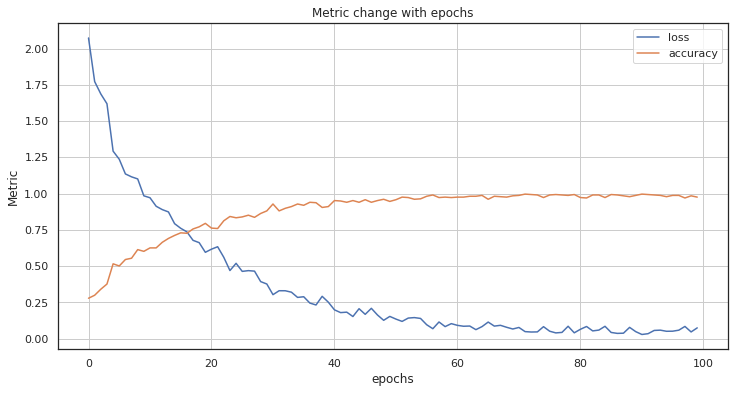

In [ ]:
model =  KerasClassifier(build_fn=get_model, verbose=0, epochs=100, batch_size=128)
history = model.fit(X_train, y_train)
pd.DataFrame(history.history).plot(figsize=(12,6))
plt.xlabel("epochs")
plt.ylabel("Metric")
plt.title('Metric change with epochs')
plt.grid()
plt.show()

In [ ]:
y_pred = model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.67      0.69        36
           1       0.93      0.87      0.90        30
           2       0.87      0.82      0.84        33
           3       0.66      0.85      0.74        34
           4       0.55      0.48      0.52        33

    accuracy                           0.73       166
   macro avg       0.74      0.74      0.74       166
weighted avg       0.74      0.73      0.73       166



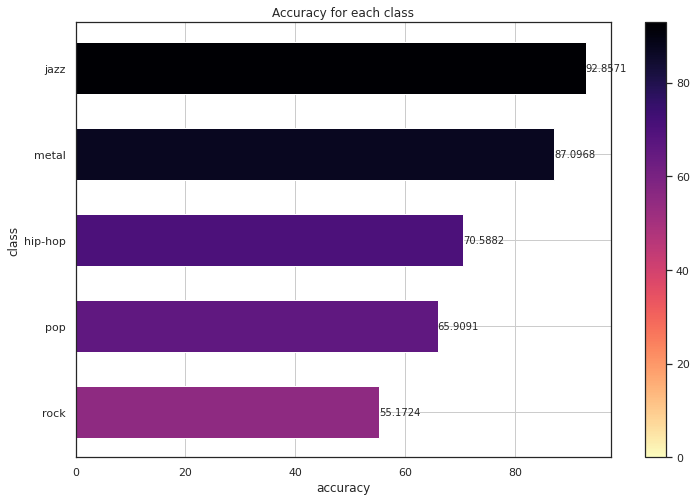

In [ ]:
ranking(accuracy_for_each_class(y_test, y_pred).sort_values(by = 'accuracy', ascending = False)['accuracy'], title='Accuracy for each class', xlabel='accuracy', ylabel='class')

It seems that classification using keras sequential model gave higher accuracy than KNN classification performed earlier. Jazz music is better distinguished than other genres. 
However, we obtained this result by a signle run without repeats. Both training loss and accuracy change stochastically throughout epochs. 

To consider stochastics behaviour in NN computations, we will run the model **repeatedly** (30 times) with **k-fold cross-validation** (cv=5) and get training & validation loss and accuracy values.

In [ ]:
res = run_keras_model(X_norm.astype('float32'), y_encoded.astype('float32'),
                      random_state_=SEED, epochs_=100)

In [ ]:
loss_train, acc_train, val_loss, val_acc = res

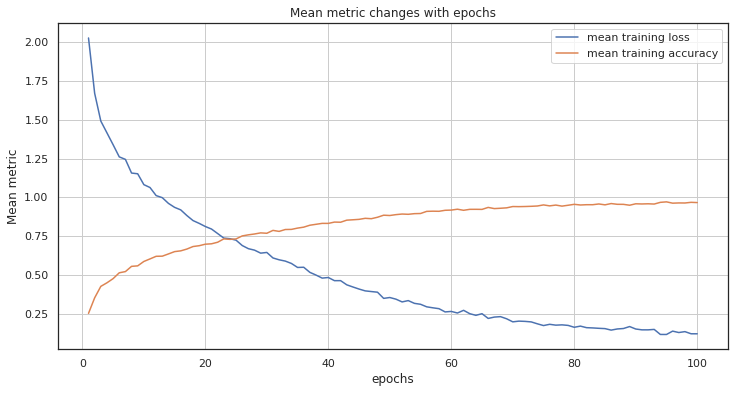

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1,101), np.mean(np.array(loss_train), axis=0))
plt.xlabel("epochs")
plt.plot(range(1,101), np.mean(np.array(acc_train), axis=0))
plt.ylabel("Mean metric")
plt.title('Mean metric changes with epochs')
plt.legend(['mean training loss', 'mean training accuracy'])
plt.grid()
plt.show()

In [ ]:
mean_acc, up_lim_acc, low_lim_acc = compute_conf_intervals(val_acc)
print(f"Mean validation accuracy on {30} repeats with {5}-fold cross-validation is {round(mean_acc, 3)},\n"
      f"the 0.95% confidence interval is [{round(up_lim_acc,3)}, {round(low_lim_acc,3)}].")

Mean validation accuracy on 30 repeats with 5-fold cross-validation is 0.769,
the 0.95% confidence interval is [0.745, 0.793].


After repeatedly (30 times) running a model on 5-fold cross-validation we obtained less stochastic, more smooth curve of training loss and accuracy changes with epochs. Obtained mean accuracy is higher than in case of KNN model. 

# Random Forest

We next apply Random Forest classifier.

In [ ]:
clf_rf = RandomForestClassifier()

In [ ]:
# parameters for tuning
parametrs = {'n_estimators': range(5, 50, 10),
             'max_depth': range(1, 10),
             'min_samples_split': range(2, 11),
             'min_samples_leaf': range(2, 10),
             'max_features': range(3, 55)}

In [ ]:
search_clf = RandomizedSearchCV(clf_rf, parametrs, cv=StratifiedKFold(5)) 

In [ ]:
# parameters tuning and tree fitting
search_clf.fit(X_train, y_train) 

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_sp...
                     

In [ ]:
# take a look at best parameters
search_clf.best_params_ 

{'max_depth': 7,
 'max_features': 19,
 'min_samples_leaf': 7,
 'min_samples_split': 3,
 'n_estimators': 15}

In [ ]:
# take best classifier
best_clf = search_clf.best_estimator_ 

In [ ]:
y_train_pred = best_clf.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90        64
           1       0.92      0.96      0.94        71
           2       0.91      0.91      0.91        68
           3       0.92      0.89      0.91        66
           4       0.79      0.81      0.80        68

    accuracy                           0.89       337
   macro avg       0.89      0.89      0.89       337
weighted avg       0.89      0.89      0.89       337



In [ ]:
y_pred = best_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.53      0.57        36
           1       0.72      0.87      0.79        30
           2       0.76      0.76      0.76        33
           3       0.62      0.68      0.65        34
           4       0.55      0.48      0.52        33

    accuracy                           0.66       166
   macro avg       0.65      0.66      0.66       166
weighted avg       0.65      0.66      0.65       166



In [ ]:
importance = best_clf.feature_importances_
features_names = X_top_5.columns.values

Text(0.5, 1.0, 'Feature importance')

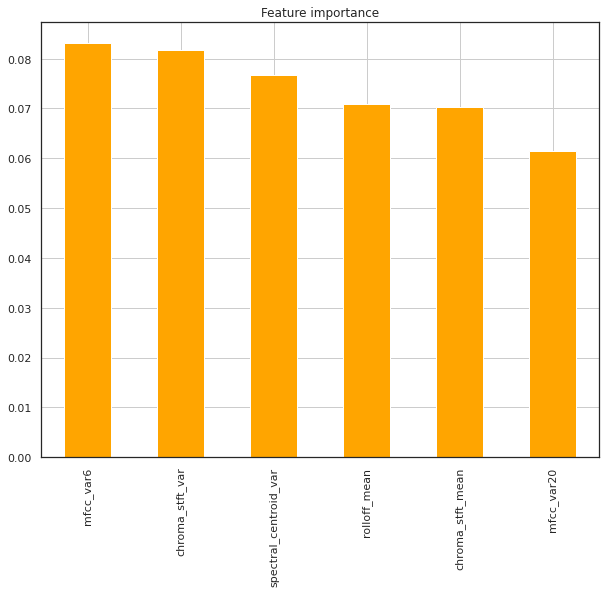

In [ ]:
plt.rcParams['font.size'] = 12
plt.subplots(figsize=(10, 8))

(pd.Series(best_clf.feature_importances_, index=X_top_5.columns)
 .nlargest(6)
 .plot.bar(color=['orange']))
plt.grid()
plt.rc('axes', axisbelow=True)
plt.title("Feature importance")

Obviously, metrics obtained with Random Forest classifier are lower than metrics obtained with Keras sequential model.


# Multilabel classification

### Idea

Our goal was to learn how to predict subgenres of music tracks by genres, prepared in the dataset of the Bioinformatics Institute.

We have updated the dataset by adding a number of new subgenres to it and combining similar genres into one. So we got the following dataset:

In [66]:
multi_lab = pd.read_csv("multi_label_music - Лист1.csv")
multi_lab.head()

,song,coarse_genre,genre1,genre2,genre3,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,7Horse_-_Answer_the_Bell.mp3,rock,blues rock,blues,unknown,0.471305,0.319938,1860.309881,2254.449006,4242.016016,0.059129,-23.744074,107.768021,0.705893,44.126892,2.450167,13.959824,-2.741955,13.074828,-1.435308,0.578150,2.607480,8.955308,0.447658,2.813950,0.683013,5.262069,-4.268339,5.835894,-3.354534,1.056222,NaN
1,A_Simple_Life-Brian_Crain.mp3,classic,neo-classic,new age piano,unknown,0.198131,0.031942,1120.163312,1258.178395,1766.280986,0.076997,-378.191803,158.049606,-12.159947,-0.245925,1.073428,-3.667623,-9.547797,-15.990136,-17.851130,-5.642962,-4.773774,-10.394959,-8.264109,3.224174,6.191852,0.026725,-8.696564,-7.645648,-0.248223,-4.363388,NaN
2,Adagio_in_G_Minor-Albinoni.mp3,classic,instrumental,unknown,unknown,0.296817,0.023875,778.658869,1176.596670,1249.834109,0.043065,-406.446533,163.899689,31.604647,24.882523,15.976170,5.303088,-14.669940,-11.307670,4.560072,8.207348,-3.151361,-10.424700,-13.281364,-3.239272,0.330685,2.051858,2.346986,3.684479,6.620385,1.746256,NaN
3,Age_Atomic-Solar_Bears.mp3,electronica,synthwave,unknown,unknown,0.465003,0.125709,1203.130772,1571.629642,2430.510303,0.037358,-229.313522,134.605347,0.550017,38.055122,12.800261,16.987812,6.436337,7.508077,3.337813,7.238113,1.483276,3.390823,1.853302,1.423907,-0.764668,-0.405367,-0.564020,1.760836,-1.767216,-3.007978,NaN
4,Alakazam_!-Justice.mp3,electronica,disco,unknown,unknown,0.519087,0.137027,4691.560922,3265.128319,8623.339523,0.322507,-94.957077,15.633355,17.379278,9.183320,11.982101,12.071534,-7.759117,3.040752,-6.754209,0.802771,-2.248677,9.931625,-1.633170,3.474230,-5.988054,5.523672,2.197058,2.507752,-3.283781,2.584341,NaN


### Preparing dataframe

We united different genres and calculated the frequency of their occurrence. To improve the accuracy of the prediction of our model and to facilitate the analysis of the results, we decided to leave only genres that occur more often 35 times in the original dataset.

So we've got 6 most common genres.

In [67]:
def multi_lab_prepare(file_path):
  final_subgenres = []
  with open(file_path) as file:
    full_gen_list = []
    subgenres = []
    file.readline()
    for line in file:
      genres = line.split(',')[1:5]
      sub_gen = list(set(genres) - {"unknown"})
      subgenres.append(sub_gen)
      for gen in sub_gen:
        full_gen_list.append(gen)
    #print(subgenres)
    counted = Counter(full_gen_list)
    gen_to_stay = []
    for key in counted:
      if counted[key] > 35:
        gen_to_stay.append(key)
    #print(gen_to_stay)
    for sample_subgen in subgenres:
      sample_subgen_new = list(set(gen_to_stay) & set(sample_subgen))
      if len(sample_subgen_new) == 0:
        sample_subgen_new.append("NA")
      final_subgenres.append(set(sample_subgen_new))
    print(gen_to_stay)
  return final_subgenres

#multi_lab_prepare("/content/drive/MyDrive/multi_label_music - Лист1.csv")
multi_lab["multi_gen"] = multi_lab_prepare("multi_label_music - Лист1.csv")
multi_lab

['rock', 'electronica', 'pop', 'hip-hop', 'metal', 'alternative']


,song,coarse_genre,genre1,genre2,genre3,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label,multi_gen
0,7Horse_-_Answer_the_Bell.mp3,rock,blues rock,blues,unknown,0.471305,0.319938,1860.309881,2254.449006,4242.016016,0.059129,-23.744074,107.768021,0.705893,44.126892,2.450167,13.959824,-2.741955,13.074828,-1.435308,0.578150,2.607480,8.955308,0.447658,2.813950,0.683013,5.262069,-4.268339,5.835894,-3.354534,1.056222,NaN,{rock}
1,A_Simple_Life-Brian_Crain.mp3,classic,neo-classic,new age piano,unknown,0.198131,0.031942,1120.163312,1258.178395,1766.280986,0.076997,-378.191803,158.049606,-12.159947,-0.245925,1.073428,-3.667623,-9.547797,-15.990136,-17.851130,-5.642962,-4.773774,-10.394959,-8.264109,3.224174,6.191852,0.026725,-8.696564,-7.645648,-0.248223,-4.363388,NaN,{NA}
2,Adagio_in_G_Minor-Albinoni.mp3,classic,instrumental,unknown,unknown,0.296817,0.023875,778.658869,1176.596670,1249.834109,0.043065,-406.446533,163.899689,31.604647,24.882523,15.976170,5.303088,-14.669940,-11.307670,4.560072,8.207348,-3.151361,-10.424700,-13.281364,-3.239272,0.330685,2.051858,2.346986,3.684479,6.620385,1.746256,NaN,{NA}
3,Age_Atomic-Solar_Bears.mp3,electronica,synthwave,unknown,unknown,0.465003,0.125709,1203.130772,1571.629642,2430.510303,0.037358,-229.313522,134.605347,0.550017,38.055122,12.800261,16.987812,6.436337,7.508077,3.337813,7.238113,1.483276,3.390823,1.853302,1.423907,-0.764668,-0.405367,-0.564020,1.760836,-1.767216,-3.007978,NaN,{electronica}
4,Alakazam_!-Justice.mp3,electronica,disco,unknown,unknown,0.519087,0.137027,4691.560922,3265.128319,8623.339523,0.322507,-94.957077,15.633355,17.379278,9.183320,11.982101,12.071534,-7.759117,3.040752,-6.754209,0.802771,-2.248677,9.931625,-1.633170,3.474230,-5.988054,5.523672,2.197058,2.507752,-3.283781,2.584341,NaN,{electronica}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,Электрослабость-Терентий.mp3,rock,rock,unknown,unknown,0.305536,0.085761,1774.842664,1615.029550,3295.796737,0.103189,-196.938995,107.890312,-49.504559,23.256870,-7.766943,-10.828805,-9.426894,-9.968717,-9.582357,-6.084743,-8.271982,-5.104860,-9.626559,-8.849612,-6.099184,-4.341605,-7.439850,0.642773,-1.910036,-0.943689,NaN,{rock}
316,Я_говорю_тебе_да-Зоя_Ященко_и_группа_Белая_Гва...,art_song,indie_rock,indie,rock,0.309073,0.113429,1486.149625,2075.468307,3159.497562,0.053756,-225.169983,112.705711,18.469475,36.379906,14.931026,11.501737,12.913817,4.283488,-4.320745,-0.780779,-6.414469,-0.155902,0.307335,3.229309,-7.142956,-6.877095,-8.012037,-2.268814,-6.735100,0.482745,NaN,{rock}
317,Я_не_один-Эм_Калинин.mp3,indie,hip-hop,unknown,unknown,0.222395,0.097399,1288.625072,1891.525926,2456.901810,0.045959,-314.401276,93.073105,30.639019,31.729876,17.475866,10.264308,-0.042682,-2.059678,-8.117323,-5.908817,-10.093952,-1.629037,-2.808756,-3.255831,3.946434,3.982924,0.635545,6.337476,-4.443654,-7.976905,NaN,{hip-hop}
318,Я_так_соскучился-Порнофильмы.mp3,rock,folk_rock,folk,unknown,0.522332,0.245946,3141.918654,2706.096095,6383.819731,0.158867,0.471008,52.295666,-6.165322,42.967606,5.009264,8.015827,0.168900,14.917789,-2.575461,8.168189,-7.770843,5.847922,-0.786887,-0.570655,-7.329313,-0.215434,-7.190438,2.377817,-5.955860,2.240076,NaN,{rock}


We presented the dependent variable as a binary dataframe

In [8]:
mlb = MultiLabelBinarizer()
preproc_mtr = mlb.fit_transform(multi_lab["multi_gen"])
multilab_df = pd.DataFrame(preproc_mtr)
colnames = list(mlb.classes_)
multilab_df2 = multilab_df.set_axis(colnames, axis=1, inplace=False)
multilab_df2 = multilab_df2.drop("NA", 1)
y = multilab_df2
y.head(10)

,alternative,electronica,hip-hop,metal,pop,rock
0,0,0,0,0,0,1
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0
5,0,1,0,0,0,0
6,0,1,0,0,0,0
7,0,0,0,0,0,0
8,0,0,0,0,0,0
9,0,0,1,0,1,0


In [9]:
multi_lab = multi_lab.drop(["song", "genre1", "genre2", "genre3", "label", "multi_gen"], axis=1)
X = multi_lab.drop(['coarse_genre'], axis=1)

In [10]:
y2 = y.loc[~(y==0).all(axis=1)]
X2 = multi_lab.drop(['coarse_genre'], axis=1)
X2 = X.loc[~(y==0).all(axis=1)]
y2.head()

,alternative,electronica,hip-hop,metal,pop,rock
0,0,0,0,0,0,1
3,0,1,0,0,0,0
4,0,1,0,0,0,0
5,0,1,0,0,0,0
6,0,1,0,0,0,0


### Applications of different models 

Binary relevance with support vector classifier:

In [42]:
hl_metrics = {}

In [52]:
# Classification using scitlearn
clf = BinaryRelevance(
    classifier=SVC()
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 40, shuffle = True)
clf.fit(X_train, pd.DataFrame(y_train))


BinaryRelevance(classifier=SVC(C=1.0, break_ties=False, cache_size=200,
                               class_weight=None, coef0=0.0,
                               decision_function_shape='ovr', degree=3,
                               gamma='scale', kernel='rbf', max_iter=-1,
                               probability=False, random_state=None,
                               shrinking=True, tol=0.001, verbose=False),
                require_dense=[True, True])

In [35]:
prediction_binrel = clf.predict(X_test)
a = prediction.todense()

In [44]:
hl_binrel = sklearn.metrics.hamming_loss(y_test, prediction)
hl_metrics["hl_binrel"] = hl_binrel
hl_binrel

{'hl_binrel': 0.20911949685534592}


**Decision Tree Classifier**

In [45]:
from sklearn.metrics import classification_report
dtree_model = DecisionTreeClassifier().fit(X_train,y_train)
dtree_predictions = dtree_model.predict(X_test)

#sklearn.metrics.classification_report(dtree_predictions, y_test)
hl_dectree = sklearn.metrics.hamming_loss(y_test, dtree_predictions)
hl_metrics["hl_dectree"] = hl_dectree
hl_dectree

0.2720125786163522

**Keras sigmoid model**

In [ ]:
# Classification using keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
model = Sequential()
model.add(Dense(5000, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.1))
model.add(Dense(600, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy',
              optimizer=sgd)

model.fit(X_train, y_train, epochs=5, batch_size=2000)

preds = model.predict(X_test)
preds[preds>=0.5] = 1
preds[preds<0.5] = 0


In [46]:
hl_keras_sigm = sklearn.metrics.hamming_loss(y_test, preds)
hl_metrics["hl_keras_sigm"] = hl_keras_sigm
hl_keras_sigm

0.20911949685534592

**Classifier chain**

In [ ]:
base_lr = LogisticRegression(solver='lbfgs', random_state=0)
chain = ClassifierChain(base_lr, order='random', random_state=0)
predict_clf_chain = chain.fit(X_train, y_train).predict(X_test)


In [47]:
hl_clf_ch_logregr = sklearn.metrics.hamming_loss(y_test, predict_clf_chain)
hl_metrics["hl_clf_ch_logregr"] = hl_clf_ch_logregr
hl_clf_ch_logregr

0.22012578616352202

So finally we've got the following hammin loss metrics for each model:

In [49]:
metric_df = pd.DataFrame([hl_metrics])
metric_df

,hl_binrel,hl_dectree,hl_keras_sigm,hl_clf_ch_logregr
0,0.209119,0.272013,0.209119,0.220126


As we can see Decision Tree Classifier is the best. So we've visualized it's results using confusion matrix.

### Visualization of prediction results



In [63]:
from sklearn.metrics import multilabel_confusion_matrix
vis_arr = multilabel_confusion_matrix(y_test, dtree_predictions)
labels = ["".join("c" + str(i)) for i in range(0, 6)]
labels = ["alternative",	"electronica",	"hip-hop",	"metal",	"pop"	,"rock"]

In [64]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

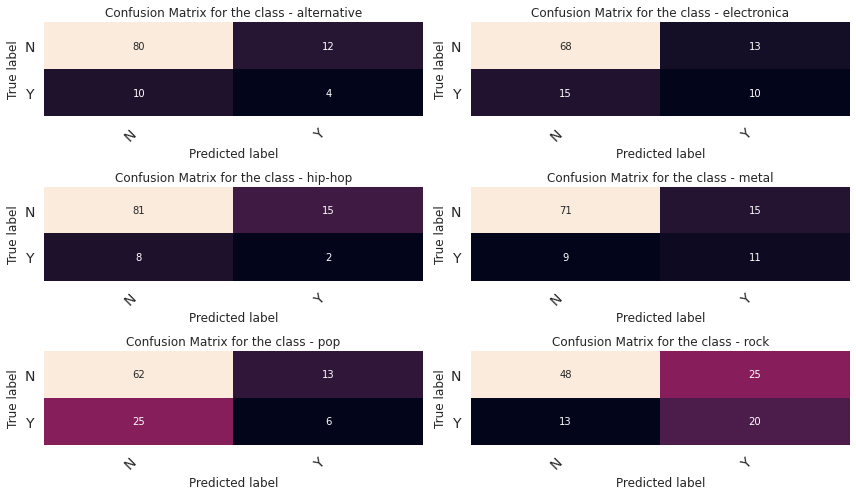

In [65]:
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

As we can see rock is best predicted. This is most likely due to the greatest representation of this genre. 

### Multilabel classification conclusion


In accordance with the results obtained, we concluded that none of the selected models provides sufficient reliability of predictions. In our opinion, this is due to the imbalance of the dataset and the low representation of various subgenres. Accordingly, such a classification does not make much sense. 